In [1]:
! git clone https://github.com/t1hachane/nckh_2025

Cloning into 'nckh_2025'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 283 (delta 98), reused 123 (delta 53), pack-reused 113 (from 1)
Receiving objects: 100% (283/283), 73.74 MiB | 45.40 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [2]:
%cd '/kaggle/working/nckh_2025/xai'

/kaggle/working/nckh_2025/xai


In [3]:
! git pull origin main

From https://github.com/t1hachane/nckh_2025
 * branch            main       -> FETCH_HEAD
Already up to date.


# 0. Imports

In [4]:
dataset_name = 'tcga-gbm-methxgexcnv-2000-3-omics'
COHORT = 'TCGA_GBM_GExCNVxMETH_2000_MinMaxScaler'

## Phase 1

In [5]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
!pip install watermark --quiet
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

In [6]:
# tmp = f'/kaggle/input/{dataset_name}'
# %cd {tmp}
%cd '/kaggle/working/nckh_2025/xai'
from models import init_model_dict
from utils import load_model_dict
from train_test import prepare_trte_data, gen_trte_adj_mat, test_epoch

from train_test import train_test
from train_test import gen_trte_adj_mat
from utils import save_model_dict

# %cd '/kaggle/working'

/kaggle/working/nckh_2025/xai


## Phase 2

In [7]:
from scipy.stats import mode
from datetime import datetime

!pip install captum --quiet
from captum.attr import IntegratedGradients, GradientShap, DeepLift

## Phase 3

In [8]:
import sklearn
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import copy
from sklearn.compose import ColumnTransformer 
from IPython.display import Markdown

import warnings
from sklearn.exceptions import ConvergenceWarning

# 1.0. Hyperparameters

In [9]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'cuda: {cuda}')
%load_ext watermark
%watermark -a 'Le Hoang' -u -d -v -p torch,numpy

cuda: True
Author: Le Hoang

Last updated: 2025-04-03

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

torch: 1.7.0
numpy: 1.19.5



In [10]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

# Config
rseed = 42
set_seed(rseed)

Random seed set as 42


In [11]:
postfix_tr = '_tr'
postfix_te = '_val'

data_folder = f'/kaggle/input/{dataset_name}/{COHORT}'
model_folder = '/kaggle/working/models'
train_file = f'/kaggle/working/nckh_2025/xai/main_mmd.py'

In [12]:
# Subtypes
loc_file_json_id_omic = data_folder + '/1/dct_index_subtype.json'
with open(loc_file_json_id_omic) as file_json_id_omic:
    dct_LABEL_MAPPING_NAME = json.load(file_json_id_omic)
    # dct_LABEL_MAPPING_NAME = {int(k): v for k,v in dct_LABEL_MAPPING_NAME.items()} # convert str number key to int
LABEL_MAPPING_NAME = dct_LABEL_MAPPING_NAME.values()

In [13]:
num_models=4
idx_list = list(range(1,num_models+1))
view_list = [1,2,3]

# Hyperparameters
num_epoch= 1500
# lr_e = 1e-4
lr = 1e-4
# dim_he_list=[250,300,150]
hidden_dim = [1000]
patience=200
verbose = False

retrain=True
bool_using_early_stopping = True
verbose = False
print_hyper = False
Run_MMD = True
testonly = False

In [14]:
# Check data size
for fold_id in [3]:
#     print(f'idx data: {fold_id}')
    tmp = list(LABEL_MAPPING_NAME)
    label_files = ['tr', 'te', 'val']
    dict = {
        'tr': 'Train set',
        'te': 'Test set',
        'val': 'Validation set'
    }
    
    print('\nCount per Subtypes: \n')
    for label_file in label_files:
        df = pd.read_csv(f'{data_folder}/{fold_id}/labels_{label_file}.csv', header=None, names=['subtypes'])
        subtype_counts = df['subtypes'].value_counts().sort_index()
        
        print(f'{dict[label_file]}')
        
        res = {}
        for subtype, count in subtype_counts.items():
            res[tmp[subtype]] = count

        print(pd.DataFrame(res, index=[0]).to_string(index=False), '\n')
    
    print('\nCount Samples: \n')
    for idx in view_list:
        res = {}
        for label_file in label_files:
            df = pd.read_csv(f'{data_folder}/{fold_id}/{idx}_{label_file}.csv', header=None)
            res[dict[label_file]] = df.shape[0]
            
        print(pd.DataFrame(res, index=[0]).to_string(index=False), '\n')
    
    print('\nCount Features: \n')
    res={}
    for idx in view_list:
        df = pd.read_csv(f'{data_folder}/{fold_id}/{idx}_featname.csv', header=None, names=['featname'])
        res[f"Omic {idx}"] = df.shape[0]
        
    print(pd.DataFrame(res, index=[0]).to_string(index=False), '\n')


Count per Subtypes: 

Train set
 Classical  Mesenchymal  Neural  Proneural
        43           48      28         43 

Test set
 Classical  Mesenchymal  Neural  Proneural
        14           16       9         15 

Validation set
 Classical  Mesenchymal  Neural  Proneural
        14           17       9         14 


Count Samples: 

 Train set  Test set  Validation set
       162        54              54 

 Train set  Test set  Validation set
       162        54              54 

 Train set  Test set  Validation set
       162        54              54 


Count Features: 

 Omic 1  Omic 2  Omic 3
   2000    2000    2000 



In [15]:
num_view = len(view_list)
num_class = len(LABEL_MAPPING_NAME)
if num_class == 2:
    adj_parameter = 2
    dim_he_list = [200,200,100]
if num_class > 2:
    adj_parameter = 10
#     dim_he_list = [400,400,200]
dim_hvcdn= pow(num_class,num_view)

In [16]:
added_softmax = False

# Prepairing raw data
def preprocessing_data(tup_tensor_test_data, data_folder):
    data_tr_list = []
    data_te_list = []
#     print(view_list)

    for i in view_list:
        data_tr_list.append(torch.tensor(np.loadtxt(os.path.join(data_folder, str(i)+"_tr.csv"), delimiter=','),dtype=torch.float32))
        data_te_list.append(tup_tensor_test_data[i-1])
        if cuda:
            data_tr_list[i-1] = data_tr_list[i-1].to(device)
            data_te_list[i-1] = data_te_list[i-1].to(device)       

    # num train's records, test's records
    num_tr = data_tr_list[0].shape[0]
    num_te = data_te_list[0].shape[0]

    # idx
    trte_idx = {}
    trte_idx["tr"] = list(range(num_tr))
    trte_idx["te"] = list(range(num_tr, (num_tr+num_te)))

    # num of views or num of omics
    num_view = len(view_list)
    data_tensor_list = []
    for i in range(num_view):
        data_tensor_list.append(torch.cat((data_tr_list[i], data_te_list[i]), axis=0))
        if cuda:
            data_tensor_list[i] = data_tensor_list[i].to(device)#cuda()
    
    data_train_list = []
    data_trte_list = []
    for i in range(len(data_tensor_list)):
        data_train_list.append(data_tensor_list[i][trte_idx["tr"]].clone())

        tup_seq_data = (data_tensor_list[i][trte_idx["tr"]].clone(), data_tensor_list[i][trte_idx["te"]].clone())
        data_trte_list.append(
            torch.cat(tup_seq_data,axis=0)
        )
    return data_train_list, data_trte_list,trte_idx


# III. For Feature Important

def custom_logit_predictor(*tup_tensor_data, data_folder):
    # Set softmax flag
    global added_softmax
    added_softmax = True

    # Move model to device
    if cuda:
        model_dict['MMDynamic'].to(device)
    model_dict['MMDynamic'].eval()

    # Process input tensors
    tup_tensor_data = tuple(tensor_data.to(device) if cuda else tensor_data 
                           for tensor_data in tup_tensor_data)

    # Preprocess data
    data_tr_list, data_trte_list, trte_idx = preprocessing_data(tup_tensor_data, data_folder)

    # Get predictions using MMDynamic model
    with torch.set_grad_enabled(True):
        predictions = model_dict['MMDynamic'].infer(data_trte_list)

    # Get test predictions
    predictions = predictions[trte_idx["te"],:]

    # Apply softmax
    if added_softmax:
        predictions = F.softmax(predictions, dim=1)

    return predictions

In [17]:
model_dict=None
def load_model(data_folder, model_folder):
    # ---- load paper's model1
    data_tr_list, data_trte_list, trte_idx, labels_trte = prepare_trte_data(data_folder, view_list, postfix_tr='_tr', postfix_te='_val')
    dim_list = [x.shape[1] for x in data_tr_list]

    global model_dict
    model_dict = init_model_dict(num_class, dim_list, hidden_dim)

    model_dict = load_model_dict(model_folder, model_dict)
    # ---- Done

In [18]:
def display_classification_report(
    n_class,
    conf_matrix,
    avg_report,
    label_mapping_name,
    cmap="Blues",
    fmt=".2%",
    annot=True,
    path=None,  # str path to save fig. If not None
    shown=True,
):
    clf_df = avg_report
    clf_df.loc[["precision", "recall"], "accuracy"] = np.nan

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    
    ConfusionMatrixDisplay(conf_matrix, display_labels=label_mapping_name).plot(cmap=cmap, ax=ax1)
    
    sns.heatmap(clf_df.iloc[:-1, :].T, annot=annot, cmap=cmap, robust=True, ax=ax2, fmt=fmt)
    
    if path is not None:
        fig.savefig(path, dpi=300)
    if shown:
        plt.show()
    else:
        plt.close(fig)

In [19]:
def calculate_average_report(reports):
    """Calculate the average classification report from a list of reports."""
    avg_report = pd.DataFrame(reports[0]).copy()
    for report in reports[1:]:
        avg_report += pd.DataFrame(report)
    avg_report /= len(reports)
    return avg_report

def evaluate_model(bool_report=True, _type_data='te'):
    conf_matrix = np.zeros((num_class, num_class), dtype=int)

    reports = []
    results = []

    for idx in idx_list:
        cur_model_folder = f'{model_folder}/{idx}'
        cur_data_folder = f"{data_folder}/{idx}/"
        load_model(cur_data_folder, cur_model_folder)

        _data_list = []

        _label = np.loadtxt(os.path.join(cur_data_folder, f"labels_{_type_data}.csv"), delimiter=',').astype(int)

        for i in view_list:
            _data_loc = os.path.join(cur_data_folder, f"{i}_{_type_data}.csv")
            _data_list.append(np.loadtxt(_data_loc, delimiter=','))
        
        _tensor_data_list = tuple(torch.tensor(np_arr, dtype=torch.float32).to(device) for np_arr in _data_list)
        pred = custom_logit_predictor(*_tensor_data_list, data_folder=cur_data_folder)
        pred = np.array(torch.argmax(pred.cpu(), dim=1))

        fold_conf_matrix = confusion_matrix(_label, pred, labels=np.arange(num_class))
        conf_matrix += fold_conf_matrix
        
        acc = accuracy_score(_label, pred)
        f1_macro = f1_score(_label, pred, average='macro')
        f1_weighted = f1_score(_label, pred, average='weighted')
        results.append((idx, acc, f1_macro, f1_weighted))

        # Get classification report for the current fold
        report = classification_report(_label, pred, target_names=LABEL_MAPPING_NAME, output_dict=True)
        reports.append(report)

    if bool_report:
        if not os.path.exists("/kaggle/working/phase1"):
            os.makedirs("/kaggle/working/phase1")
        
        # Calculate average classification report
        avg_report = calculate_average_report(reports)
        
        # Calculate the average of the models
        df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1 Macro', 'F1 Weighted'])
        avg_row = ['Average', df['Accuracy'].mean(), df['F1 Macro'].mean(), df['F1 Weighted'].mean()]
        df.loc[len(df)] = avg_row

        print(df.to_string(index=False))

        # Display confusion matrix and classification report
        display_classification_report(
            num_class,
            conf_matrix,
            avg_report,
            LABEL_MAPPING_NAME,
            path=f"/kaggle/working/phase1/Evaluate_model_{_type_data}",
        )

    return avg_report['macro avg']['f1-score']

# 1.1. TRAINING

In [20]:
if retrain:
    model_folder = '/kaggle/working/models'
    for fold_id in idx_list:
        print(f'idx data: {fold_id}')

        data_folder_idx = data_folder + f'/{fold_id}'
        model_folder_idx = model_folder + f'/{fold_id}'

        if not bool_using_early_stopping:
            patience=None
        
        print(patience)
        !python '{train_file}' '{rseed}' '{data_folder_idx}' \
            '{postfix_tr}' '{postfix_te}' '{model_folder_idx}' \
            '{view_list}' '{num_epoch}'  '{lr}'  '{testonly}' \
            '{hidden_dim}' '{print_hyper}' \
            '{patience}' '{verbose}' '{model_folder}'
        print('*'*100)
else:
    model_folder = f'/kaggle/input/{dataset_name}/models'

idx data: 1
200

Training...
Early stop at epoch 415th after 200 epochs not increasing score from epoch 215th with best score 0.8895451965375337
Early stopping triggered. Using best model from epoch 215
****************************************************************************************************
idx data: 2
200

Training...
Early stop at epoch 373th after 200 epochs not increasing score from epoch 173th with best score 0.8713793922127256
Early stopping triggered. Using best model from epoch 173
****************************************************************************************************
idx data: 3
200

Training...
Early stop at epoch 370th after 200 epochs not increasing score from epoch 170th with best score 0.8366281213340038
Early stopping triggered. Using best model from epoch 170
****************************************************************************************************
idx data: 4
200

Training...
Early stop at epoch 573th after 200 epochs not increasing s

# 1.2. Load trained models and check accuracy phase 1

   Model  Accuracy  F1 Macro  F1 Weighted
       1  0.993827  0.992758     0.993800
       2  0.993827  0.994463     0.993821
       3  1.000000  1.000000     1.000000
       4  1.000000  1.000000     1.000000
 Average  0.996914  0.996805     0.996905


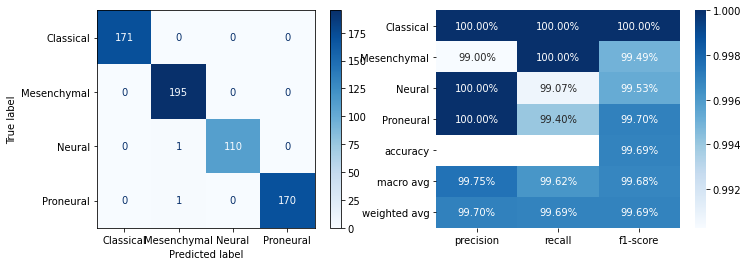

   Model  Accuracy  F1 Macro  F1 Weighted
       1  0.888889  0.895329     0.890413
       2  0.833333  0.826916     0.832993
       3  0.814815  0.809211     0.816539
       4  0.777778  0.773144     0.774046
 Average  0.828704  0.826150     0.828498


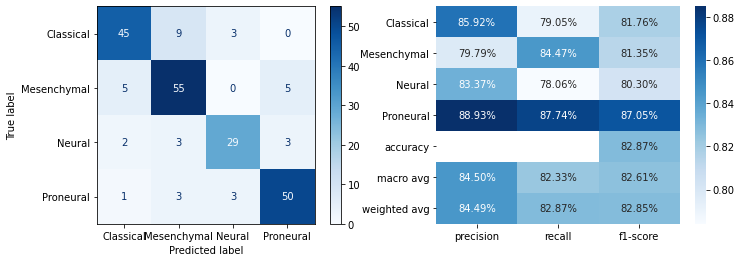

   Model  Accuracy  F1 Macro  F1 Weighted
       1  0.777778  0.770982     0.779365
       2  0.759259  0.746337     0.758242
       3  0.740741  0.721324     0.742018
       4  0.759259  0.729636     0.752930
 Average  0.759259  0.742070     0.758139


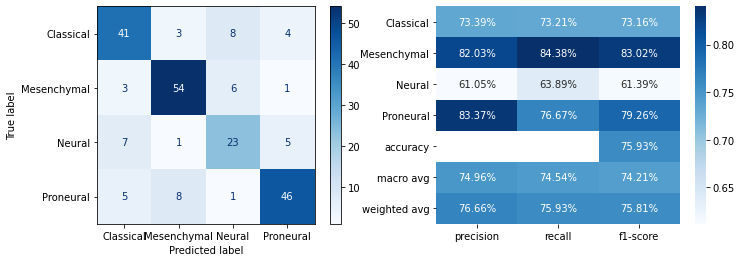

0.742069748745569

In [21]:
evaluate_model(_type_data='tr')
evaluate_model(_type_data='val')
evaluate_model(_type_data='te')

# MODULE 2: Integrated Gradient

In [22]:
biomarkers_folder = '/kaggle/working/biomarkers/' + COHORT
postfix_tr = '_tr'
postfix_te = '_val'

# 2.1. Baselines for IG

In [23]:
# Load dict mapping name of {int_id_label:label_name} that int_id_label start from 0 and {int_id_omic:omic_name} that int_id_omic start from 1
loc_file_json_id_label = data_folder + '/1/dct_index_subtype.json'
loc_file_json_id_omic = data_folder + '/1/dict_id_omics.json'

with open(loc_file_json_id_label) as file_json_id_label:
    dct_LABEL_MAPPING_NAME = json.load(file_json_id_label)
    dct_LABEL_MAPPING_NAME = {int(k): v for k,v in dct_LABEL_MAPPING_NAME.items()} # convert str number key to int
# print("\n{int_id_label:label_name} = ", dct_LABEL_MAPPING_NAME)

with open(loc_file_json_id_omic) as file_json_id_omic:
    dct_OMIC_MAPPING_NAME = json.load(file_json_id_omic)
    dct_OMIC_MAPPING_NAME = {int(k): v for k,v in dct_OMIC_MAPPING_NAME.items()} # convert str number key to int
# print("\n{int_id_omic:omic_name} = ", dct_OMIC_MAPPING_NAME)



###############

# may be fixed
n_folds = num_models # fold id start from 1
type_data = 'tr' # fixed
fold_start_id = 1
list_fold_id = list(range(n_folds+fold_start_id)[fold_start_id:])


dict_fold_dict_baseline = {}

for fold_id in list_fold_id:
    data_folder_idx = data_folder + f'/{fold_id}'
#     print(f'\n*Using data of fold_id= "{fold_id}" with data type = "{type_data}" for each omic (total "{len(dct_OMIC_MAPPING_NAME)}" type(s) of omic) in folder "{data_folder_idx}" to create baseline')
    ##############
    tmp_label = pd.read_csv(os.path.join(data_folder_idx, f'labels_{type_data}.csv'), header=None)

    tmp_dict_omic_pd_data = {id_omic: pd.read_csv(os.path.join(data_folder_idx, f'{str(id_omic)}_{type_data}.csv'), header=None) for id_omic in dct_OMIC_MAPPING_NAME.keys()}
    tmp_dict_omic_shape = {id_omic: tmp_dict_omic_pd_data[id_omic].shape[1] for id_omic in dct_OMIC_MAPPING_NAME.keys()} # number of features each omic
    
    tmp_dict_omic_pd_data_w_label = {id_omic: tmp_dict_omic_pd_data[id_omic].copy(deep=True) for id_omic in dct_OMIC_MAPPING_NAME.keys()}
    for id_omic in tmp_dict_omic_pd_data_w_label.keys():
        tmp_dict_omic_pd_data_w_label[id_omic]['subtype'] = tmp_label[0]

    tmp_dict_baseline= {}
    
    #############################
    tmp_dict_baseline['zeros']= tuple(torch.zeros((1,tmp_dict_omic_shape[id_omic])
                                              , dtype=torch.float32) for id_omic in dct_OMIC_MAPPING_NAME.keys())
    tmp_dict_baseline['micro_means']= tuple(torch.tensor(tmp_dict_omic_pd_data[id_omic].mean(axis=0).values.reshape(1,-1)
                                                         , dtype=torch.float32) for id_omic in dct_OMIC_MAPPING_NAME.keys())
    tmp_dict_baseline['macro_means']= tuple(torch.tensor(tmp_dict_omic_pd_data_w_label[id_omic].groupby('subtype').mean().mean(axis=0).values.reshape(1,-1)
                                                         , dtype=torch.float32) for id_omic in dct_OMIC_MAPPING_NAME.keys())
    ##########################################################

    tmp_dict_baseline['dict_default_micro_means']= {}
    
    tmp_list_of_list_exclude_cursor_label_id = [sorted(list(set(dct_LABEL_MAPPING_NAME.keys()) - set([label_id]))) for label_id in dct_LABEL_MAPPING_NAME.keys()]
    tmp_dict_baseline['dict_default_macro_means']= {}
    
    for label_id in dct_LABEL_MAPPING_NAME.keys():
        tmp_dict_baseline['dict_default_macro_means'][label_id] = tuple(
            torch.tensor(
                tmp_dict_omic_pd_data_w_label[id_omic].groupby('subtype').sum().loc[tmp_list_of_list_exclude_cursor_label_id[label_id]].mean(axis=0).values.reshape(1,-1)
                ,dtype=torch.float32
            ) for id_omic in dct_OMIC_MAPPING_NAME.keys()
        )
        
        tmp_dict_baseline['dict_default_micro_means'][label_id] = tuple(
            torch.tensor(
                tmp_dict_omic_pd_data_w_label[id_omic][
                    tmp_dict_omic_pd_data_w_label[id_omic]['subtype'] != label_id # filter to exclude row have label is {label_id}
                ].loc[:,tmp_dict_omic_pd_data_w_label[id_omic].columns != 'subtype' # then filter to exclude column of label before cal mean for all columns
                     ].sum(axis=0).values.reshape(1,-1)
                ,dtype=torch.float32
            ) for id_omic in dct_OMIC_MAPPING_NAME.keys()
        )
    ##########################################################
     
    # Final assign
    dict_fold_dict_baseline[fold_id] = tmp_dict_baseline
    
    print(f'For fold_id = "{fold_id}" Done create all baseline type/with name:\n\tin {list(tmp_dict_baseline.keys())}')

For fold_id = "1" Done create all baseline type/with name:
	in ['zeros', 'micro_means', 'macro_means', 'dict_default_micro_means', 'dict_default_macro_means']
For fold_id = "2" Done create all baseline type/with name:
	in ['zeros', 'micro_means', 'macro_means', 'dict_default_micro_means', 'dict_default_macro_means']
For fold_id = "3" Done create all baseline type/with name:
	in ['zeros', 'micro_means', 'macro_means', 'dict_default_micro_means', 'dict_default_macro_means']
For fold_id = "4" Done create all baseline type/with name:
	in ['zeros', 'micro_means', 'macro_means', 'dict_default_micro_means', 'dict_default_macro_means']


In [24]:
def calculate_attribution_scores_for_folder(input, _label, cur_data_folder, idx_model, type_base_line, _n_steps=100):
    
    # Initialize Integrated Gradients with the custom model predictor
    # ig = IntegratedGradients(lambda *inputs: custom_logit_predictor(*inputs, data_folder=cur_data_folder))
    ig = GradientShap(lambda *inputs: custom_logit_predictor(*inputs, data_folder=cur_data_folder))
    # ig = DeepLift(model_dict)
    number_of_samples = len(_label)
    
    # Calculate attribute scores by batch data to avoid running out of memory
    # 200 is the maximum (approximate) number of samples that will not cause run out of memory with this TCGA BRCA data (on Train data)
    max_samples_per_batch = 100
    # Get list end of index to split data into batches
    list_end_index = [max_samples_per_batch*times 
                      for times in range(1,int(np.ceil(number_of_samples/max_samples_per_batch)))
                     ] + [number_of_samples]
    
    attr = {}
    for subtype_idx, subtype in enumerate(LABEL_MAPPING_NAME):
        #----------------------------------------
        start = 0
#             print(f'\n\t\t<> Calculate attribution scores with subtype: "{subtype}":')


        if type_base_line[:4] == 'dict':
#                 print(f'\t\t Type baseline:\n\t\t  [{type_base_line}] -> Special baseline for each subtype')
            baseline = dict_fold_dict_baseline[idx_model][type_base_line][subtype_idx]
        else:
#                 print(f'\t\t Type baseline:\n\t\t  [{type_base_line}]')
            baseline = dict_fold_dict_baseline[idx_model][type_base_line]
        if cuda:
            baseline = tuple(tensor_i.cuda() for tensor_i in baseline)
#             print(f'\t\t Model pred score:\n\t\t  {custom_logit_predictor(*baseline, data_folder=cur_data_folder).detach().cpu().numpy()} -> SUM={torch.sum(custom_logit_predictor(*baseline, data_folder=cur_data_folder)).detach().cpu().numpy()}')

        for end in list_end_index:
#                 print(f'\t\t\t:samples from iloc {start} to {end}:')

            input_tensor = tuple(input_omic[start:end].requires_grad_() for input_omic in input)

            # attr_temp, delta_temp = ig.attribute(input_tensor,
            #                                      baselines=baseline,
            #                                      target= subtype_idx, return_convergence_delta=True,
            #                                     n_steps=_n_steps)

            # GradientSHAP
            attr_temp, delta_temp = ig.attribute(input_tensor,
                                                 baselines=baseline,
                                                 target= subtype_idx, return_convergence_delta=True,)
            
            # concatenate genes attribute score for multi-omics data
            attr_temp = np.concatenate(tuple(attr_temp[idx_atr].detach().cpu().numpy() for idx_atr in range(len(attr_temp))), axis=1)
            if start == 0:
                attr[subtype] =  attr_temp
            else:
                attr[subtype] = np.concatenate((attr[subtype],attr_temp),axis=0)
            start=end
#             print(f'\t\t\t: [Delta temp: min={delta_temp.min()}, max={delta_temp.max()}, mean={delta_temp.mean()}, std={delta_temp.std()}]\n')

    return attr

# 2.2. Calculate and Sort IG's score of each feature from: train data + trained model

In [25]:
topn=10

In [26]:
def cal_feat_imp(num_models, type_base_line ='zeros',_n_steps=100, type_data='tr'):
    
    loc_file_json_id_omic = data_folder + '/1/dct_index_subtype.json'
    with open(loc_file_json_id_omic) as file_json_id_omic:
        dct_LABEL_MAPPING_NAME = json.load(file_json_id_omic)
    LABEL_MAPPING_NAME = dct_LABEL_MAPPING_NAME.values() 
    
    start_time=datetime.now()
    
    dct_feat_imp_by_models = {}
    for idx_model in range(1,num_models+1):
        data_folder_idx = data_folder + f'/{idx_model}'
        model_folder_idx = model_folder + f'/{idx_model}'
        added_softmax = True
        
        # loading dataset
        _data_list=[]
        _label = np.loadtxt(os.path.join(data_folder_idx, f"labels_{type_data}.csv"), delimiter=',').astype(int)

        for i in view_list:
            _data_loc = os.path.join(data_folder_idx, str(i)+ f"_{type_data}.csv")
            _data_list.append(np.loadtxt(_data_loc, delimiter=','))
        _tensor_data_list = tuple(torch.tensor(np_arr,dtype=torch.float32).to(device) for np_arr in _data_list)

        gene_name = []
        for v in view_list:
            df = pd.read_csv(os.path.join(data_folder_idx, str(v)+"_featname.csv"), header=None)    
            gene_name.extend(df[0].values.tolist())
            # DONE USE THIS: gene_name.extend(df[0].str.split(r'\|').str[0].values.tolist()) # only used when want combined same features that first part before | symbol if exist

        
        ## load models weights
        load_model(data_folder_idx, model_folder_idx)
        
        #---------------------------------------------------------------------

        # Calculate attribute score:
        attr = calculate_attribution_scores_for_folder(_tensor_data_list, _label, data_folder_idx, idx_model, type_base_line, _n_steps)
        
        # ------------------------------
        lst_ordered_subtype = list(attr.keys())
        stack_subtype_attr = np.stack(tuple(attr[subtype] for subtype in lst_ordered_subtype))
        feat_imp_like_each_class = np.abs(stack_subtype_attr).mean(axis=1)
        feat_imp_like = feat_imp_like_each_class.sum(axis=0)
        
        dct_feat_imp_by_models[idx_model] = feat_imp_like
    
    # along models
    final_feat_imp_like = np.mean(list(dct_feat_imp_by_models.values()), axis=0)

    idx_sorted_desc_mean_abs_sum = np.argsort(final_feat_imp_like)[::-1] # Note hien tai dang khong quan tam examples nao dung, example nao du doan sai nhu mot so cach o duoi day
    sorted_score_feat_imp_like = final_feat_imp_like[idx_sorted_desc_mean_abs_sum]
    rank_imp_feats_by_abs_mean_sum_without_combine_same_gene_name = list(np.array(gene_name)[idx_sorted_desc_mean_abs_sum])
    pd_rank_by_abs_mean_sum = pd.DataFrame({'gene_name': rank_imp_feats_by_abs_mean_sum_without_combine_same_gene_name}) #, 'score':sorted_score_feat_imp_like
    print(f'\t=>Result (Here print out the top {topn} biomakers with highest values):')
    
    end_time=datetime.now()
    print(f'\tRun in {end_time-start_time}')
    
    display(pd_rank_by_abs_mean_sum.head(topn))
    return pd_rank_by_abs_mean_sum

In [27]:
def export_biomarker_file(list_concerned_type_baseline, list_concerned_type_data, list_concerned_num_models, biomarkers_folder, _n_steps=100):
    list_biomakers_file_loc = []
    print('_'*100)
    print(f'Biomarker Discovery for {biomarkers_folder.split("/")[-1]} cohort:')
    pd_results = {}
    for type_base_line in list_concerned_type_baseline:
        pd_results[type_base_line] = {}
        for type_data in list_concerned_type_data:
            pd_results[type_base_line][type_data] = {}
            for num_models in list_concerned_num_models:
                
                pd_results[type_base_line][type_data][num_models] = cal_feat_imp(num_models=num_models,type_base_line=type_base_line,_n_steps=n_steps, type_data= type_data)

                if not os.path.exists(biomarkers_folder):
                    os.makedirs(biomarkers_folder)
                    
                biomakers_file_loc = biomarkers_folder + f'/IG_{type_base_line}_{type_data}_{num_models}_{data_folder.split("/")[-1]}.csv'
                pd_results[type_base_line][type_data][num_models][['gene_name']].to_csv(biomakers_file_loc, index=False)
                list_biomakers_file_loc.append(biomakers_file_loc)

    print()
    return list_biomakers_file_loc

In [28]:
list_concerned_type_baseline = ['zeros', 'micro_means', 'macro_means', 'dict_default_micro_means', 'dict_default_macro_means']
# list_concerned_type_baseline = ['zeros']
list_concerned_type_data = ['tr']
list_concerned_num_models = [num_models]

n_steps=100

list_biomakers_file_loc = export_biomarker_file(list_concerned_type_baseline, list_concerned_type_data, list_concerned_num_models, biomarkers_folder, n_steps)

____________________________________________________________________________________________________
Biomarker Discovery for TCGA_GBM_GExCNVxMETH_2000_MinMaxScaler cohort:


/opt/conda/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:307: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


AttributeError: 'dict' object has no attribute 'register_forward_pre_hook'

# 2.3. MOGONET(NO IG)

In [ ]:
if Run_MMD:
    biomarker_file_name = f'mogonet_full_top_biomarkers_sorted_desc_score_{num_models}models.csv'
    main_biomarker_mogonet = '/kaggle/working/nckh_2025/xai/main_biomarker.py'

    start_time=datetime.now()
    print(main_biomarker_mogonet)
    !python '{main_biomarker_mogonet}' '{data_folder}' '{model_folder}' '{dim_he_list}' '{view_list}' '{num_models}' '{postfix_tr}' '{postfix_te}' '{biomarkers_folder}' '{biomarker_file_name}' '{topn}'
    print(f'\t=>Result (Here print out the top {topn} biomakers with highest values):')
    end_time=datetime.now()
    print(f'\tRun in {end_time-start_time}')

# 3. PHASE 3

In [ ]:
# Threshold to take number of genes (biomarkers) per subtype
print(dct_OMIC_MAPPING_NAME)
ROOT_DATA_FOLDER = f'/kaggle/input/{dataset_name}/{COHORT}/train_test_split_org/'
RANDOM_STATE = 42

LIST_OMICS = list(dct_OMIC_MAPPING_NAME.values())
print(LIST_OMICS)
LIST_OMICS_ID = np.arange(1,len(LIST_OMICS)+1,1)

# Single omic or Multi-omics| to run experiments
LIST_EXP_OMICS = ['_'.join(LIST_OMICS)]
print(LIST_EXP_OMICS)


LIST_TYPE_DATA = ['train', 'test']
DATA_FOLDER = {'train': ROOT_DATA_FOLDER,
              'test': ROOT_DATA_FOLDER}


loc_file_json_id_label = data_folder + '/1/dct_index_subtype.json'
with open(loc_file_json_id_label) as file_json_id_label:
    dct_LABEL_MAPPING_NAME = json.load(file_json_id_label)
    dct_LABEL_MAPPING_NAME = {int(k): v for k,v in dct_LABEL_MAPPING_NAME.items()}
ORIGINAL_MAPPING_NAME = dct_LABEL_MAPPING_NAME
print(ORIGINAL_MAPPING_NAME)

In [ ]:
BIOMARKERS_RESULT_FOLDER = '/kaggle/working/biomarkers'
list_loc_biomarkers = []
for dirname, _, filenames in os.walk(BIOMARKERS_RESULT_FOLDER):
    for filename in filenames:
        list_loc_biomarkers.append(os.path.join(dirname, filename))
# print(list_loc_biomarkers)

# 3.1. Check overlap with other genes

In [ ]:
direct_evidence_gene_list = [
    "EGFR", "MGMT", "CXCL8", "H2AX", "VEGFA", "EGF", "MMP2", "HIF1A", "MMP9", "IL1B",
    "MYC", "CDK6", "MTOR", "HES1", "FN1", "NDRG1", "CTSB", "PTK2", "CD9", "PROM1",
    "WT1", "FAT1", "HEY1", "DUSP6", "NCOR1", "NOTCH1", "BMI1", "BHLHE40", "TP53BP1", "PIM1",
    "MET", "JAG1", "CSTA", "CHI3L1", "APC", "CTSK", "NOTCH2", "FAM83D", "GSTT1", "FOSL2",
    "GDNF", "TES", "PRKN", "SUZ12", "CSTB", "ZBTB7A", "BCHE", "RUNX1", "CCNH", "LRRC59",
    "PML", "POLK", "SRRT", "RUNX3", "CTNND2", "TMEM135", "MDM4", "H3-3A", "BRD2", "TRMT11",
    "NF1", "HOXD10", "GRIK2", "JAG2", "BRD4", "LTBP4", "MACIR", "NOTCH3", "LZTR1", "H3C2",
    "SLC22A10", "DEUP1", "SEPTIN14", "TGM2", "TNFSF10", "IL2", "RECK", "IFNA2"
]
topn_lst = [50, 100, 200, 400]

In [ ]:
data = []

for file_loc in list_loc_biomarkers:
    file_name = file_loc.split('/')[-1]
    ig_biomarkers = pd.read_csv(file_loc).iloc[:, 0].str.split(r'\|').str[0].values.tolist()
    baseline_name = '-'.join(file_name.split('_')[:-7])
    for i in topn_lst:
        intersect_direct = sorted(list(set(direct_evidence_gene_list).intersection(set(ig_biomarkers[:i]))))
        intersect_direct_str = ', '.join(intersect_direct)
        data.append([baseline_name, i, intersect_direct_str]) #, intersect_reference, intersect_inference])

df = pd.DataFrame(data, columns=['Baseline', 'TopN', 'Intersect with Direct Evidence Gene List']) #, 'Intersect with Top Reference Gene List', 'Intersect with Top Inference Gene List'])

# Print table
pd.set_option('display.max_colwidth', None)
display(df)

df.to_csv("/kaggle/working/genes_overlap.csv", index=False)

# 3.2. TEST WITH CLASSIC ML ALGO

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', None)
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [ ]:
def display_classification_report(
    n_class,
    label,
    pred,
    label_mapping_name,
    cmap="Blues",
    fmt=".2%",
    annot=True,
    path=None,  # str path to save fig. If not None
    shown=True,
):

    clf_report = classification_report(
        label,
        pred,
        target_names=label_mapping_name,
        digits=4,
        zero_division=0,
        output_dict=True,
    )

    clf_df = pd.DataFrame(clf_report)
    clf_df.loc[["precision", "recall"], "accuracy"] = np.nan
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    ConfusionMatrixDisplay(
        confusion_matrix(label, pred), display_labels=label_mapping_name
    ).plot(cmap=cmap, ax=ax1)
    sns.heatmap(
        clf_df.iloc[:-1, :].T, annot=annot, cmap=cmap, robust=True, ax=ax2, fmt=fmt
    )
    if path is not None:
        fig.savefig(path, dpi=300)
    if shown:
        plt.show()
    else:
        plt.close(fig)

In [ ]:
def tuning_and_eval(gridcvs, X_train, y_train, X_test, y_test,
                    scoring, refit, is_binary_problem,
                    result_on_dataset, rank_hparams_info):
    assert 'test' in result_on_dataset
    assert isinstance(rank_hparams_info, bool)
    ###
    lst_dct_result = [] # to return
    ###

    start=datetime.now()
    X = {}
    y = {}
    X['train'] = X_train
    X['test'] = X_test
    y['train'] = y_train
    y['test'] = y_test

    for model_name, gs_est in sorted(gridcvs.items()):
        ###
        sub_result = {}
        sub_result['model'] = model_name
        ###

        start_individual_type_model = datetime.now()
        gs_est.fit(X['train'],y['train'])

        ###
        sub_result['best_params'] = gs_est.best_params_
        ###

        ###
        sub_result[f'best_tuning_{refit}'] = gs_est.best_score_ * 100
        sub_result['best_tuning_std'] = gs_est.cv_results_[f'std_test_{refit}'][gs_est.best_index_] * 100
        ###

        if rank_hparams_info:
            select_result_cols = []
            for metric in scoring:
                select_result_cols.extend(['rank_test_'+metric,'mean_test_'+ metric, 'std_test_'+metric])
            select_result_cols.extend(['params'])

            dataframe_results = pd.DataFrame(gs_est.cv_results_).loc[:,select_result_cols].sort_values(by=f'mean_test_{refit}',ascending=False)
            display(dataframe_results[:10])

        for type_data in result_on_dataset:
            y_predict = gs_est.predict(X[type_data])

            acc = accuracy_score(y_true=y[type_data], y_pred=y_predict)

            ###
            sub_result[f'{type_data}_acc'] = acc * 100
            ###

            if is_binary_problem:
                f1 = f1_score(y_true=y[type_data], y_pred=y_predict,average='binary')
                y_score = gs_est.predict_proba(X[type_data])[:, 1]
                roc_auc = roc_auc_score(y_true=y[type_data], y_score=y_score)

                ###
                sub_result[f'{type_data}_f1'] = f1 * 100
                ###

                ###
                sub_result[f'{type_data}_roc_auc'] = roc_auc * 100
                ###
            else:
                f1_macro = f1_score(y_true=y[type_data], y_pred=y_predict,average='macro')
                f1_weighted = f1_score(y_true=y[type_data], y_pred=y_predict,average='weighted')

                ###
                sub_result[f'{type_data}_f1_macro'] = f1_macro * 100
                ###

                ###
                sub_result[f'{type_data}_f1_weighted'] = f1_weighted * 100
                ##

            ###
            lst_dct_result.append(sub_result)
            ###

#             pd_cfm = pd.crosstab(
#                 y[type_data]
#                 , y_predict
#                 , margins=True
#                 , rownames=['True label']
#                 , colnames=['Pred label']
#             )
            
#             for label in ORIGINAL_MAPPING_NAME.values():
#                 if label not in pd_cfm.index:
#                     pd_cfm.loc[label] = 0
#                 if label not in pd_cfm.columns:
#                     pd_cfm[label] = 0

#             pd_cfm = pd_cfm.reindex(index=list(ORIGINAL_MAPPING_NAME.values()) + ['All'], 
#                                     columns=list(ORIGINAL_MAPPING_NAME.values()) + ['All'])

#             display(pd_cfm)
            
            folder_save_fig = f"/kaggle/working/cfm/{biomarker_file.split('/')[-1].split('.')[-2]}/{model_name}"
            if not os.path.exists(folder_save_fig):
                os.makedirs(folder_save_fig)
            path_save_fig = f"{folder_save_fig}/top{threshold}.png"
            display_classification_report(n_class=len(ORIGINAL_MAPPING_NAME)
                                          , label=y[type_data]
                                          , pred= y_predict
                                          , label_mapping_name=ORIGINAL_MAPPING_NAME.values()
                                          , path=path_save_fig
                                          , shown=False
                                         )
    return lst_dct_result

In [ ]:
def validate_biomarker(dict_X_train, dict_y_train, dict_X_test, dict_y_test,
                       omics=['GE_CNA', 'GE','CNA'], random_state = RANDOM_STATE,
                       result_on_dataset = ['train','test'], rank_hparams_info = True,
                       is_binary_problem=False):
    assert 'test' in result_on_dataset
    assert isinstance(rank_hparams_info, bool)
    ###
    validate_biomarker_result = []
    ###
    scoring = None
    refit= None
    if is_binary_problem:
        scoring = ['f1','accuracy','roc_auc']
        refit = 'f1'
    else: 
        scoring = ['f1_macro','f1_weighted', 'accuracy']
        refit = 'f1_macro'

    # Initializing classifiers
    clf1 = LogisticRegression(random_state=random_state, max_iter=10000, n_jobs=-1)

    # Binary case, probability = True to cal ROC_AUC, slowdown k-fold....
    clf2 = SVC(random_state=random_state, probability=is_binary_problem)

    clf3 = RandomForestClassifier(random_state=random_state,n_jobs=-1)

    # Building the pipelines
    pipe1 = Pipeline([('std', 'passthrough'),
                      ('clf1', clf1)])

    pipe2 = Pipeline([('std', 'passthrough'),
                      ('clf2', clf2)])

#     # only apply std to mRNA data/ BY index mRNA| ignore or passthorough not to
#     # apply standard scaler to remaining index corresponding to CNA data
#     column_trans = ColumnTransformer(
#         [('scaler', StandardScaler(),list(range(len(GENE['mRNA']))))]
#         ,remainder='passthrough')
    # Setting up the parameter grids
    param_grid1 = [{
                    'std': [MinMaxScaler()],
                    'clf1__penalty': ['l2'],
                    'clf1__multi_class':["multinomial"],
                    'clf1__solver':["newton-cg"],
                    'clf1__class_weight': ["balanced"],
                    'clf1__C': np.power(10., np.arange(-4, 3)),
                    }]

    param_grid2 = [{
                    'std': [MinMaxScaler()],
                    'clf2__kernel': ['rbf'],
                    'clf2__class_weight': ["balanced"],
                    'clf2__C': np.power(10., np.arange(-4, 3)),
                    'clf2__gamma': list(np.power(10., np.arange(-4, 0))) + ['scale']
                    }]

    param_grid3 = [{'n_estimators': [50, 100, 150],
                    'max_features': ["sqrt"],
                    'max_depth' : list(range(1, 10)) + [None],
                    'criterion' :["gini"],
                    'class_weight': ["balanced", "balanced_subsample"]}]

    # Setting up multiple GridSearchCV objects, 1 for each algorithm
    gridcvs = {}
#     cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10, random_state=random_state)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=random_state)

    train_options = zip(
                        (param_grid1,
                         param_grid2,
                         param_grid3,
                        ),
                        (pipe1,
                         pipe2,
                         clf3,
                        ),
                        ('1_Softmax',
                         '2_SVM',
                         '3_RandomForest',
                        )
                       )

    for pgrid, est, model_name in train_options:
        gcv = GridSearchCV(estimator=est,
                           param_grid=pgrid,
                           scoring=scoring,
                           n_jobs=-1,
                           cv=cv,
                           verbose=0,
                           refit=refit)
        gridcvs[model_name] = gcv

    for omic in omics:
#         print('-'*100)
#         printmd(f'Validate on {omic} data:\n', color="red")

        X_train = dict_X_train[omic]
        y_train = np.array(dict_y_train[omic], dtype=np.int16)
#         print('Train dist: ', np.unique(y_train, return_counts=True ))

        X_test = dict_X_test[omic]
        y_test = np.array(dict_y_test[omic], dtype=np.int16)
#         print('Test dist', np.unique(y_test, return_counts=True ),'\n')

        # run tuning and eval
        tmp_lst_dct_tuning_result = tuning_and_eval(gridcvs, X_train, y_train, X_test, y_test,\
                        scoring, refit,is_binary_problem,
                        result_on_dataset, rank_hparams_info)
        ###
        tmp_base= {'using_omic': omic}
        validate_biomarker_result.extend([copy.deepcopy(tmp_base) for i in range(len(tmp_lst_dct_tuning_result))])
        for dct_tmp, dct_val in zip(tmp_lst_dct_tuning_result, validate_biomarker_result):
            dct_val.update(dct_tmp)
        ###
    return validate_biomarker_result

In [ ]:
def validate(biomarker_file, threshold):
    # init var and para to save the result
    ###
    validate_result=[]
    base_result = {}
    ###
#     dct_data_structure = {col: [] for col in lst_cols}
#     pd_result = pd.DataFrame(columns=lst_cols)

    # Read data
    dict_df_label = {}
    dict_df_data = {}
    # Read data as df and create numpy array data for labeled data
    for type_data in LIST_TYPE_DATA:
        # modified
        dict_df_label[type_data] = pd.read_csv(DATA_FOLDER[type_data] + f'labels_{type_data[:2]}.csv', names=['disease_subtypes'])
        # ---------------------------------

        # added
        dict_df_label[type_data]['disease_subtypes'] = dict_df_label[type_data]['disease_subtypes'].astype('int')
        dict_df_label[type_data].index.names = ['sampleID']
        
        dict_df_label[type_data].replace({'disease_subtypes': ORIGINAL_MAPPING_NAME}, inplace=True)
        # ---------------------------------
        
        
        dict_df_omics = {}
        dict_narray_omics = {}
        for omic in LIST_OMICS:
            # added
            tmp_feat_name = pd.read_csv(DATA_FOLDER[type_data]+ f'{LIST_OMICS.index(omic)+1}_featname.csv', names=['feat_name'])
#             tmp_feat_name['feat_name'] = tmp_feat_name['feat_name'].str.split('|').str[0]
            lst_name = tmp_feat_name.values.reshape(-1).tolist()
            # ---------------------------------

            # modified
            dict_df_omics[omic] = pd.read_csv(DATA_FOLDER[type_data] + f'{LIST_OMICS.index(omic)+1}_{type_data[:2]}.csv',names=lst_name)
            # ---------------------------------

        dict_df_data[type_data] = dict_df_omics

    LABEL_MAPPING_NAME = dict_df_label['train']['disease_subtypes'].astype('category').cat.categories # sorted by alphabetical order
#     print('LABEL_MAPPING_NAME', LABEL_MAPPING_NAME)
    
    # Convert categorical label to numerical label
    for type_data in LIST_TYPE_DATA:
        dict_df_label[type_data].loc[:,'disease_subtypes'] = dict_df_label[type_data]['disease_subtypes'].astype('category').cat.codes

    #---------------------------------------------------------------------------------------
    # Keep only biomarker genes found from TCGA data
#     print('-'*100)
#     print('KEEP ONLY BIOMARKER GENES FOUND FROM TCGA DATA')
    score_genes = pd.read_csv(biomarker_file)
    score_genes = score_genes.iloc[:threshold, 0]
    top_genes = list(set(score_genes.to_numpy(copy=True).reshape(-1)))
#     print(top_genes)
    top_genes = [gene.upper() for gene in top_genes]
#     print(f'Top {threshold} from TCGA have {len(top_genes)} unique genes/features:')
    ###
    base_result['n_unq_markers'] = len(top_genes)
    base_result['lst_unq_markers'] = top_genes
    ###
    
    GENE = {}
    for omic in LIST_OMICS:
        GENE[omic] = dict_df_data['train'][omic].columns[
#             dict_df_data['train'][omic].columns.str.upper().str.split(r'\|').str[0].isin(top_genes)
            dict_df_data['train'][omic].columns.str.upper().isin(top_genes)
        ].to_numpy(copy=True).tolist()

#         print(f'\twith {omic} TOP {threshold}:', len(GENE[omic]))
        ###
        base_result[f'n_unq_{omic}'] = len(GENE[omic])
        base_result[f'lst_unq_{omic}'] = GENE[omic]
        ###
    # NOTE THAT DNAmythyl and mRNA maybe have same genename in top gene => incresing num features comparing to num unique genes

        for type_data in LIST_TYPE_DATA:
            dict_df_data[type_data][omic] = dict_df_data[type_data][omic][GENE[omic]].copy(deep=True)
    
    dict_X = {}
    dict_y = {}
    for type_data in LIST_TYPE_DATA:
        dict_X[type_data] = {}
        dict_y[type_data] = {}

    for type_omic in LIST_EXP_OMICS:
        if '_' in type_omic:
#             print(f'Creating data for multi-omics experiment: {type_omic}')
            list_omics = type_omic.split('_')
            for type_data in LIST_TYPE_DATA:
                tuple_data_omics = tuple([dict_df_data[type_data][single_omic] for single_omic in list_omics])
                dict_X[type_data][type_omic] = np.concatenate(tuple_data_omics, axis=1)
        else:
#             print(f'Creating data for single omic experiment: {type_omic}')
            for type_data in LIST_TYPE_DATA:
                dict_X[type_data][type_omic] = dict_df_data[type_data][type_omic].to_numpy(copy=True)

        for type_data in LIST_TYPE_DATA:
            dict_y[type_data][type_omic] = dict_df_label[type_data]['disease_subtypes'].to_numpy(copy=True)


    #---------------------------------------------------------------------------------------
    tmp_lst_dct_validate_biomarker_result = validate_biomarker(dict_X['train'], dict_y['train'], dict_X['test'], dict_y['test'],
                       omics=LIST_EXP_OMICS, random_state=RANDOM_STATE,
                       result_on_dataset= ['test'], rank_hparams_info =False,
                       is_binary_problem = (len(LABEL_MAPPING_NAME)==2))
    validate_result.extend([copy.deepcopy(base_result) for i in range(len(tmp_lst_dct_validate_biomarker_result))])
    for dct_tmp, dct_val in zip(tmp_lst_dct_validate_biomarker_result, validate_result):
        dct_val.update(dct_tmp)
    return validate_result

In [ ]:
# excluded_files = ['mogonet_full_top_biomarkers_sorted_desc_score_5models.csv']
# excluded_files = [f'{BIOMARKERS_RESULT_FOLDER}/{COHORT}/'+biomarker_file for biomarker_file in excluded_files]

excluded_files = [] # evaluation all candidate biomarkers result

In [ ]:
print(pd.__version__)
print(sklearn.__version__)
print(np.__version__)

In [ ]:
# # Ignore ConvergenceWarning
# warnings.filterwarnings("ignore", category = ConvergenceWarning)

##
result = []
THRESHOLD_LST = list(range(25, 401, 25))
##

for biomarker_file in list_loc_biomarkers:
    if biomarker_file in excluded_files:
        continue
#     print("*"*100)
    baseline = biomarker_file.split('/')[-1].split('.')[-2]
    printmd(baseline,'green')
#         print(biomarker_file)

    start = datetime.now()
    for threshold in THRESHOLD_LST:
        ###
        tmp_result = []
        base_init_dct_result = {'top': threshold, 'baseline': baseline}
        tmp_validate_result = validate(biomarker_file,threshold)
        tmp_result.extend([copy.deepcopy(base_init_dct_result) for i in range(len(tmp_validate_result))])
        for dct_tmp, dct_val in zip(tmp_validate_result, tmp_result):
            dct_val.update(dct_tmp)

        result.extend(tmp_result)
        
    print(f'Total Time: {datetime.now()-start}')
        ###
#         print(f"Top {threshold} - Using {tmp_result[0]['n_unq_markers']} uniques biomarkers in totals")
#         print(tmp_result[0]['lst_unq_markers'])
#         print('\n'*2)

# 3.3. Compare all IG baselines and MOGONET

In [ ]:
avg_acc_all_models = {}
avg_f1_all_models = {}
filtered_results = []

for res in result:
#         print(res)
    model_type = res['model']
    baseline_type = "-".join(res['baseline'].split('_')[:-7])
    top_n = res['top']
    accuracy_t = res['test_acc']
    f1_score_t = res.get('test_f1_macro', res.get('test_f1', 0))

    filtered_results.append({
        'model_type': model_type,
        'baseline_type': baseline_type,
        'top_n': top_n,
        'accuracy_t': accuracy_t,
        'f1_score_t': f1_score_t
    })
    
    if model_type not in avg_acc_all_models:
        avg_acc_all_models[model_type] = {}
        avg_f1_all_models[model_type] = {}

    if baseline_type not in avg_acc_all_models[model_type]:
        avg_acc_all_models[model_type][baseline_type] = []
        avg_f1_all_models[model_type][baseline_type] = []

    avg_acc_all_models[model_type][baseline_type].append((top_n, accuracy_t))
    avg_f1_all_models[model_type][baseline_type].append((top_n, f1_score_t))
        
for model_type in avg_acc_all_models:
    for baseline_type in avg_acc_all_models[model_type]:
        avg_acc_all_models[model_type][baseline_type].sort(key=lambda x: x[0])
        avg_f1_all_models[model_type][baseline_type].sort(key=lambda x: x[0])

In [ ]:
def plot_metrics(metrics, metric_name):
    folder_save_fig = f"/kaggle/working/cmp"
    if not os.path.exists(folder_save_fig):
        os.makedirs(folder_save_fig)
    path_save_fig = f'{folder_save_fig}/{metric_name}.png'
    plt.figure(figsize = (8,4), dpi=300)
    for baseline_name, values in metrics.items():
        top_n_list = [item[0] for item in values]
        metric_values = [item[1] for item in values]
        plt.plot(top_n_list, metric_values, marker='o', label=baseline_name)
    plt.title(f'{metric_name} for different baselines and top N features')
    plt.xlabel('Top N features')
    plt.ylabel(metric_name)
    plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')    
    plt.xticks(top_n_list)
    plt.yticks(list(range(35, 91, 5)))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(path_save_fig, facecolor='white', edgecolor='white')
    plt.show()
    
# Plot accuracy
for model_type in avg_acc_all_models.keys():
    print('*' * 40, model_type, '*' * 40)
    plot_metrics(avg_acc_all_models[model_type], f'Accuracy for {model_type}')
    plot_metrics(avg_f1_all_models[model_type], f'F1 Score for {model_type}')
    print('\n\n')

In [ ]:
# Convenient for modifying plot
json_file = "/kaggle/working/results.json"

with open(json_file, mode='w', encoding='utf-8') as file:
    json.dump(filtered_results, file, ensure_ascii=False, indent=4)